In [2]:
%matplotlib inline
import numpy as np
import math
import warnings
from skimage import io
from pylab import *
from matplotlib import pylab as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.core.display import clear_output

warnings.simplefilter("ignore")

In [3]:
def bresenham(x1, y1, x2, y2):
    x = x1
    y = y1
    points = []
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2

    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y1

    points.append([x,y])
    
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                x += xi
                d += bi
            points.append([x,y])
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                y += yi
                d += bi
            points.append([x,y])

    return points

In [4]:
def sum_points(points, img):
    sumOfPoints = 0.0
    for point in points:
        sumOfPoints += img[point[0],point[1]]
    return sumOfPoints

In [5]:
def coordToCart(angle, cx, cy, radius):
    x = int(math.cos(math.radians(angle)) * radius) + cx
    y = int(math.sin(math.radians(angle)) * radius) + cy
    return x,y

In [6]:
def filterKernel(size):
    img = np.zeros(size)
    center = int(size/2)
    img[center] = 1.0
    for i in range(1, size-center):
        if i % 2 == 0:
            img[center+i] = 0.0
            img[center-i] = 0.0
        elif i % 2 != 0:
            img[center+i] = (-4/(math.pi)**2)/i**2
            img[center-i] = (-4/(math.pi)**2)/i**2
            
    return img

In [7]:
def doTomography(img, emiterAngles, inc_angle, emiterRange=60.0, detectors=201, withFilter=True):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    emiters = img.copy()
    img_size = img.shape[0]
    centre = int(img_size/2)
    radius = centre-5
    
    if (detectors % 2 != 1):
        detectors += 1
    
    if withFilter:
        splotFunc = filterKernel(detectors)
    sinogram = np.zeros((len(emiterAngles),detectors))

    #petla - kazda pozycja emitera
    for angle in emiterAngles:
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        emiters[emiter_y, emiter_x] = 255
    
        sin_results = np.zeros(detectors)
        #petla - kazda pozycja detektora
        
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)
            
            #sinogram[int(angle/inc_angle),a] = sum_points(points, img)
            sin_results[a] = sum_points(points, img)
        
        if withFilter:
            sinogram[int(angle/inc_angle),:] = np.convolve(sin_results, splotFunc, 'same')
        else:
            sinogram[int(angle/inc_angle),:] = sin_results
        
    return emiters, sinogram



def createOffset(img, offset=2):
    square_size = img.shape[0]
    side = int((int(square_size*offset) - square_size)/2)
    image = np.zeros((int(square_size*offset),int(square_size*offset)))
    for i in range(square_size):
        for j in range(square_size):
            image[i+side,j+side]= img[i,j]
    return image

def delOffset(img, offset=2):
    img_size = img.shape[0]
    new_size = int((img_size/offset))
    side = int((img_size-new_size)/2)
    image = np.zeros((new_size,new_size))
    image[:,:] = img[side:side+new_size, side:side+new_size]
    return image 

def createSquare(square_size=500):
    square = 255*np.ones((square_size,square_size), dtype=np.float64)
    return square

def normalize(img):
    min_value = np.min(img)
    max_value = np.max(img)
    for i in range(len(img)):
        for j in range(len(img[i])):
            img[i,j]=(img[i,j] - min_value)/(max_value-min_value) *255
            
    return img

In [8]:
def meanError(imgIn, imgOut):
    if imgIn.shape != imgOut.shape:
        return 0
    
    error = 0.0
    for i in range(len(imgIn)):
        for j in range(len(imgIn[i])):
            error = error + (imgIn[i,j]-imgOut[i,j])**2
            
    error = error / (imgOut.shape[0]*imgOut.shape[1])
    
    return error


def blurImage(img):
    #print(len(img))
    newImage = np.zeros((len(img),len(img[0])),dtype=np.float64)
    #print(newImage)
    for i in range(len(img)):
        for j in range(len(img[i])):
            if(i!=0 and i!=len(img)-1 and j!=0 and j!=len(img[i])-1):
                newImage[i,j] = (img[i-1,j-1] + img[i-1,j]*2 + img[i-1,j+1] + img[i,j-1]*2 + img[i,j]*3 + img[i,j+1]*2 + img[i+1,j-1] + img[i+1,j]*2 + img[i+1,j+1])/15
            else:
                newImage[i,j] = img[i,j]
    return newImage

In [9]:
def cutDownValues(img, cutDownValue = 15):
    for i in range(len(img)):
        for j in range(len(img[i])):
            img[i,j] = img[i,j] - cutDownValue if img[i,j] - cutDownValue > 0 else 0
    return img

In [15]:

def doInvTomography(imgBase, sinogram, img_size, emiterAngles, inc_angle, offset, emiterRange=60.0, detectors=201):
    # Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
    beta = emiterRange*2
    centre = int(img_size/2)
    radius = centre-5
    #print(sinogram)
    img = np.zeros((img_size, img_size))
    
    if (detectors % 2 != 1):
        detectors += 1
        
    meanErrors = np.zeros(len(emiterAngles))

    #petla - kazda pozycja emitera
    for i, angle in enumerate(emiterAngles):
        emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
        

        #petla - kazda pozycja detektora
        for a in range(detectors):
            alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
            detx, dety = coordToCart(alfa, centre, centre, radius)
            #image[detx,dety] = 155
            if dety < emiter_y:
                points = bresenham(detx, dety, emiter_x, emiter_y)
            else:
                points = bresenham(emiter_x, emiter_y, detx, dety)

            for point in points:
                img[point[0], point[1]] += int(sinogram[int(angle/inc_angle), a]/len(points))
        
        
        meanErrors[i] = meanError(imgBase, delOffset(img, offset))
        #if i%60==0:
         #   fig = figure(figsize=(40,20))
          #  subplot(6,1,i//60+1)
           # imshow(img, cmap='gray')
        #print(meanErrors[i], imgBase.shape==delOffset(img, offset).shape, imgBase.shape, delOffset(img, offset).shape)
        
    return img, meanErrors

def main(file='square', square_size=500, offset=2, 
         inc_angle=0.5, emiterRange=60.0, detectors=201, withFilter = False, toAngle = 360):
    if file != 'square':
        img = mpimg.imread(file)
    else:
        img = createSquare(square_size)
    
    #obrazek wyjsciowy z offsetem
    fig = figure(figsize=(80,40))
    imgWithOffset = createOffset(img, offset)
        
    
    #imageNumber = 7
        
    #subplot(imageNumber,1,1)
    #imshow(img, cmap='gray')
    imgSize = imgWithOffset.shape[0]
    
    #sinogram
    emiterAngles = np.linspace(0, toAngle, toAngle/inc_angle, endpoint=False)
    emiters, sinogram = doTomography(imgWithOffset, emiterAngles, inc_angle, emiterRange, detectors, withFilter)
    #subplot(imageNumber,1,2)
    #imshow(sinogram, cmap='gray')
    
    
    #obrazem z sinogramu
    imgFromSinogram, meanErrors = doInvTomography(img, sinogram, imgSize, emiterAngles, inc_angle, offset, emiterRange, detectors)
    #subplot(imageNumber,1,3)
    #imshow(imgFromSinogram, cmap='gray')
    
    #obciecie offsetu
    imgToCompare = delOffset(imgFromSinogram, offset)
        
    bluredImage = blurImage(imgToCompare)
    #subplot(imageNumber,1,4)
    #imshow(bluredImage, cmap='gray')
        
    normalized_image = normalize(bluredImage)
    #subplot(imageNumber,1,5)
    #imshow(normalized_image, cmap='gray')
    
    cutDownImage = cutDownValues(normalized_image,cutDownValue = 50)
    #subplot(imageNumber,1,6)
    #imshow(cutDownImage,cmap='gray')


    #x = np.linspace(0, len(meanErrors), len(meanErrors), endpoint=False)
    #fig1, ax = plt.subplots()
    #ax.plot(x, meanErrors)

    
    #plt.figure()
    #subplot(1,3,1), plt.imshow(img, cmap='gray')
    #subplot(1,3,2), plt.imshow(sinogram, cmap='gray')
    #subplot(1,3,3), plt.imshow(cutDownImage, cmap='gray')
    #plt.savefig('2.pdf')
    
    #plt.figure()
    #subplot(1,1,1), plt.plot(x, meanErrors)
    #plt.savefig('error2.pdf')
    
    return meanError(img, cutDownImage)

In [11]:
def interaction(inc_angle, emiterRange, detectors, offset):
    main(file = 'ph.jpg', inc_angle=inc_angle, emiterRange=float(emiterRange), detectors=detectors, offset = offset, withOffset = True, withFilter=False)

In [18]:
from ipywidgets import FloatSlider
def interaction(inc_angle, emiter_angle, detectors, offset, toAngle, withFilter):
    main(file = 'ph.jpg', inc_angle=inc_angle, emiterRange=float(emiter_angle), detectors=detectors, offset = offset, toAngle = toAngle, withFilter = withFilter)
interact_manual(interaction, inc_angle = FloatSlider(min=0.1,max=10,step=0.1,value=0.5), toAngle = widgets.IntSlider(min=30,max=360,step=10,value=180), emiter_angle = widgets.IntSlider(min=20,max=85,step=5,value=70),detectors = widgets.IntSlider(min=20,max=200,step=5,value=70), offset = FloatSlider(min=1,max=5,step=0.5,value=1.5), withFilter = True)

interactive(children=(FloatSlider(value=0.5, description='inc_angle', max=10.0, min=0.1), IntSlider(value=70, description='emiter_angle', max=85, min=20, step=5), IntSlider(value=70, description='detectors', max=200, min=20, step=5), FloatSlider(value=1.5, description='offset', max=5.0, min=1.0, step=0.5), IntSlider(value=180, description='toAngle', max=360, min=30, step=10), Checkbox(value=True, description='withFilter'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.interaction>

In [17]:
detectorsError = []
for i in range(51, 202, 25):
    detectorsError.append(main(file = 'ph.jpg', inc_angle=1, emiterRange=70.0, detectors=i, offset = 1.5, withFilter=True))
    
x = np.linspace(50, 200, 7)
plt.figure()
subplot(1,1,1), plt.plot(x, detectorsError)
plt.savefig('error_det1.pdf')

KeyboardInterrupt: 

<Figure size 5760x2880 with 0 Axes>

(360,) [4.39723102e+03 3.66168829e+03 3.39974548e+03 3.63541025e+03
 4.36655735e+03 5.61164857e+03 7.32143982e+03 9.53092546e+03
 1.21970069e+04 1.53583190e+04 1.89349861e+04 2.29851925e+04
 2.74600615e+04 3.23953234e+04 3.77027003e+04 4.34376085e+04
 4.95870847e+04 5.61055953e+04 6.29925261e+04 7.02770040e+04
 7.78549406e+04 8.58007741e+04 9.40704722e+04 1.02617680e+05
 1.11428965e+05 1.20562145e+05 1.29956342e+05 1.39595448e+05
 1.49488138e+05 1.59629415e+05 1.70025742e+05 1.80635254e+05
 1.91471225e+05 2.02535857e+05 2.13894872e+05 2.25511632e+05
 2.37321282e+05 2.49351495e+05 2.61674173e+05 2.74230690e+05
 2.87071115e+05 3.00094573e+05 3.13410971e+05 3.26928267e+05
 3.40734556e+05 3.54777347e+05 3.69088302e+05 3.83646535e+05
 3.98529517e+05 4.13660639e+05 4.29125959e+05 4.44827906e+05
 4.60797948e+05 4.77040469e+05 4.93494047e+05 5.10273600e+05
 5.27273743e+05 5.44543719e+05 5.62013852e+05 5.79665815e+05
 5.97533340e+05 6.15641769e+05 6.33939963e+05 6.52503261e+05
 6.71344665e+05 6

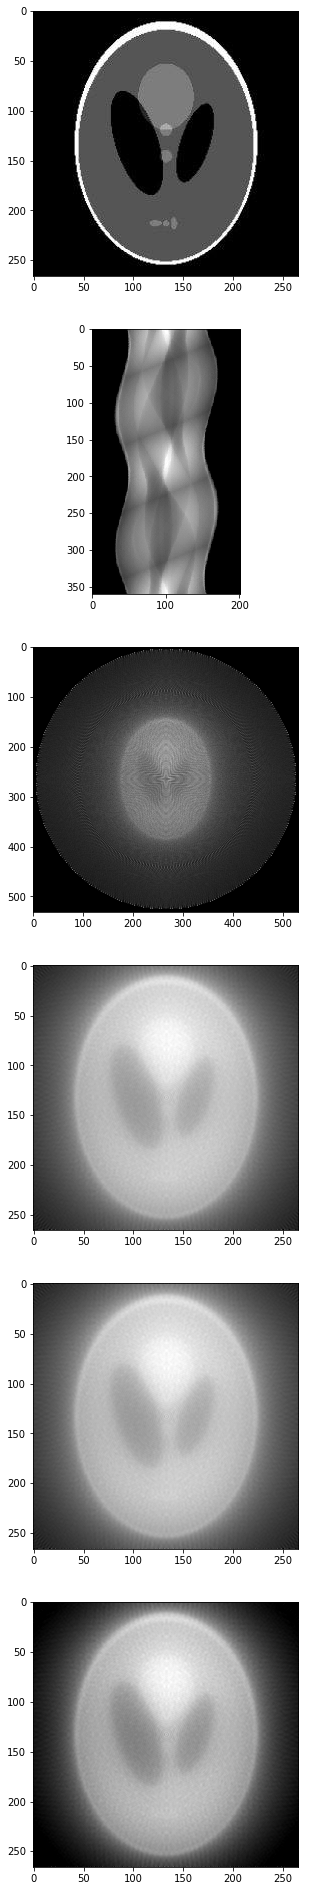

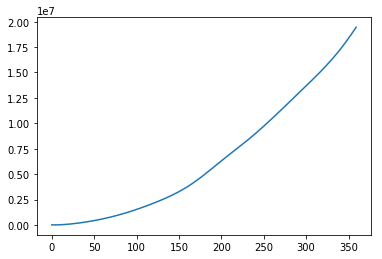

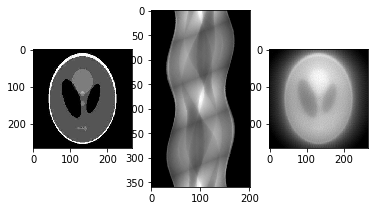

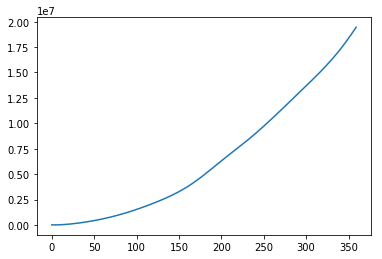

<function __main__.interaction>

In [217]:

interact(interaction, inc_angle = 1, emiterRange = 80,detectors = 201, offset = 2)